In [39]:
import os
import pandas as pd
import re
import numpy as np
import os
import keras
import urllib.request
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sentencepiece as spm
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TextClassificationPipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from collections import Counter
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras import layers

import torch
import torch.nn as nn
import sklearn.metrics

import random
import logging
from IPython.display import display, HTML
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [13]:
df = pd.read_csv('~/aiffel/DKTC/train.csv')

df.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [16]:
def check_class(it):
    if '협박' in it:
        return 0
    elif '갈취' in it:
        return 1
    elif '직장 내 괴롭힘' in it:
        return 2
    elif '기타 괴롭힘' in it:
        return 3
    else:
        return 4
df['label'] = df['class'].apply(lambda it: check_class(it))

df.head()

,idx,class,conversation,data,label
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,1


In [17]:
import re

def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence
df['data'] = df['conversation'].apply(lambda it : preprocess_sentence(it))

df.head()

,idx,class,conversation,data,label
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,1


협박           896
갈취           981
직장 내 괴롭힘     979
기타 괴롭힘      1094
Name: idx, dtype: int64


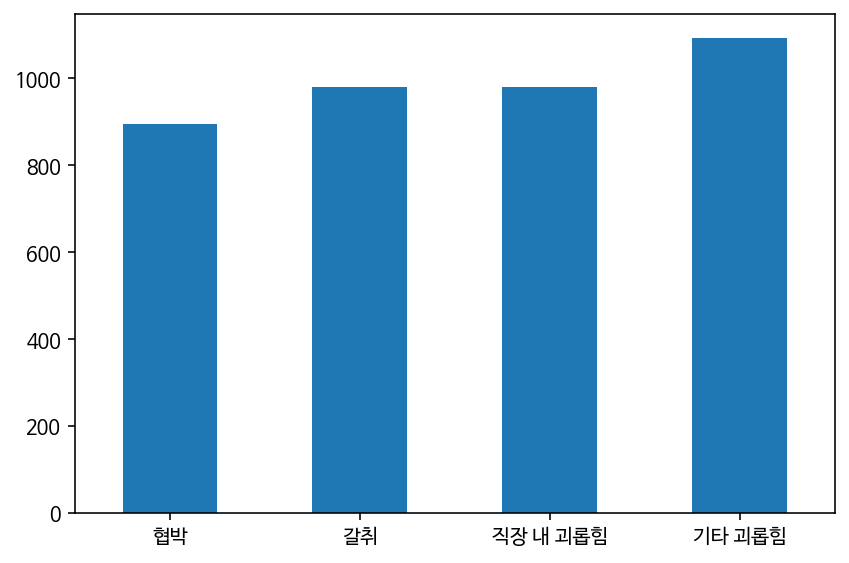

In [18]:
group_count = df.groupby("label").count().iloc[:,0]
group_count.index = ['협박', '갈취', '직장 내 괴롭힘',  '기타 괴롭힘']

print(group_count)

group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

문장의 최단 길이: 41
문장의 최장 길이: 909
문장의 평균 길이: 236


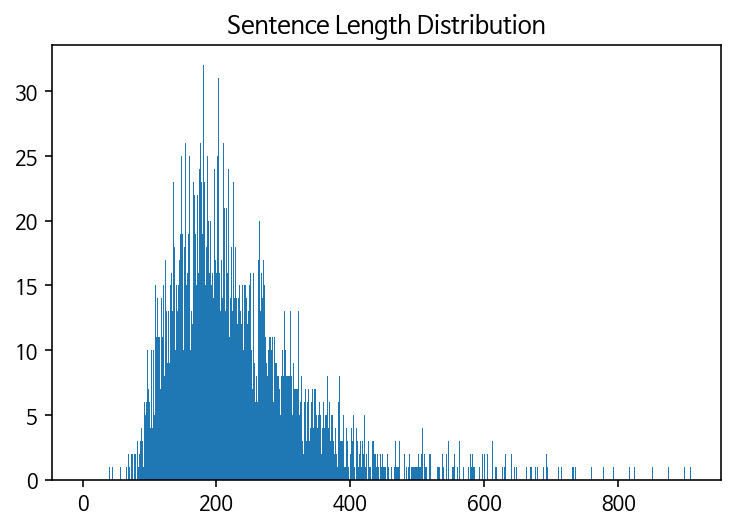

In [34]:
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

label = df["class"]
sentence = df["data"]

# 데이터프레임 생성
df_boxplot = pd.DataFrame({"Class": label, "Sentence Length": [len(s) for s in sentence]})

#최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현
min_len = 999
max_len = 0
sum_len = 0

raw = []
for sent in df['data']:
  raw.append(sent)

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [32]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

print(len(train_data))
print(len(test_data))
print(len(valid_data))

3199
395
356


## Fine tuning

In [30]:
from transformers import AutoModel, AutoTokenizer
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [33]:
tokenized_train_sentences = tokenizer(
    list(train_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

tokenized_test_sentences = tokenizer(
    list(test_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '민', '##수', '##씨', '이', '##것', '##좀', '우', '##체', '##국', '##가', '##서', '부', '##치고', '##와', '우', '##체', '##국', '##이', '##요', '?', '?', '응', '우', '##체', '##국', '계', '##장', '##님', '급', '##한', '##건', '##가', '##요', '?', '?', '급', '##하', '##니', '##까', '갔', '##다', '##오', '##라고', '##했', '##지', '제', '##가', '차', '##가', '없는', '##데', '동', '##기', '##한', '##테', '물', '##어', '##보', '##고', '같이', '다', '##녀', '##와', '##도', '될', '##까', '##요', '민', '##수', '##씨', '.', '차', '##가', '없는', '##건', '민', '##수', '##씨', '사', '##정이', '##고', '나는', '급', '##하', '##니', '##까', '걸', '##어', '##서', '가', '##든', '버', '##스', '##타', '##고', '가', '##든', '알', '##아', '##서', '다', '##녀', '##와', '네', '?', '여기서', '걸', '##어', '##가', '##면', '우', '##체', '##국', '##까지', '시', '##간이', '##고', '버', '##스', '##도', '드', '##문', '##드', '##문', '다', '##니', '##는데', '여', '##기', '시', '##골', '##이', '##라', '그', '##런', '곳', '##인',

In [34]:
train_label = train_data['label'].values
test_label = test_data['label'].values

print(train_label[0])
print(test_label[0])

2
3


In [35]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)
     

In [37]:
train_dataset[0]

/tmp/ipykernel_101/193649156.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'input_ids': tensor([   101,   9311,  15891,  49212,   9638, 118627, 119212,   9604,  29683,
          20479,  11287,  12424,   9365, 108613,  12638,   9604,  29683,  20479,
          10739,  48549,    136,    136,   9636,   9604,  29683,  20479,   8887,
          13890, 108578,   8929,  11102,  71439,  11287,  48549,    136,    136,
           8929,  35506,  25503, 118671,   8852,  11903,  28188,  59894, 119424,
          12508,   9672,  11287,   9730,  11287,  40364,  28911,   9095,  12310,
          11102, 119351,   9299,  12965,  30005,  11664,  38401,   9056,  50814,
          12638,  12092,   9100, 118671,  48549,   9311,  15891,  49212,    119,
           9730,  11287,  40364,  71439,   9311,  15891,  49212,   9405,  98489,
          11664, 100585,   8929,  35506,  25503, 118671,   8867,  12965,  12424,
           8843,  90537,   9336,  12605,  22695,  11664,   8843,  90537,   9524,
          16985,  12424,   9056,  50814,  12638,   9011,    136, 108954,   8867,
          12965

In [40]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

num_labels = 4

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Step,Training Loss
500,0.901900
1000,0.567500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_101/193649156.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_101/193649156.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training completed. D

TrainOutput(global_step=1200, training_loss=0.6686471875508626, metrics={'train_runtime': 966.6095, 'train_samples_per_second': 9.929, 'train_steps_per_second': 1.241, 'total_flos': 2525122141581312.0, 'train_loss': 0.6686471875508626, 'epoch': 3.0})

In [41]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)
     

trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 395
  Batch size = 64
/tmp/ipykernel_101/193649156.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Trainer is attempting to log a value of "[0.84946237 0.84259259 0.91011236 0.83809524]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.88764045 0.78448276 0.89010989 0.88888889]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.81443299 0.91       0.93103448 0.79279279]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5100783705711365,
 'eval_accuracy': 0.8582278481012658,
 'eval_f1': array([0.84946237, 0.84259259, 0.91011236, 0.83809524]),
 'eval_precision': array([0.88764045, 0.78448276, 0.89010989, 0.88888889]),
 'eval_recall': array([0.81443299, 0.91      , 0.93103448, 0.79279279]),
 'eval_runtime': 13.0144,
 'eval_samples_per_second': 30.351,
 'eval_steps_per_second': 0.538}